In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import pickle
from scipy.linalg import hankel
from scipy.optimize import minimize
import matplotx
from time import time

plt.style.use(matplotx.styles.aura["dark"])

In [160]:
def trial_xticks(ax, xlocs, yloc=-0.04):
    xlocs = np.array(xlocs)
    ax.set_xticks(xlocs)
    ax.set_xticklabels([])
    ax.tick_params("x", length=17, width=1, which="major")
    ax.set_xlabel("Time", labelpad=10)

    periods = ["S", "Cue", "Delay", "Arm", "Reward"]
    for i in range(5):
        xloc = xlocs[i] + (xlocs[i + 1] - xlocs[i]) / 2
        ax.text(
            xloc,
            yloc,
            periods[i],
            fontsize=10,
            horizontalalignment="center",
            verticalalignment="top",
            transform=ax.get_xaxis_transform(),
            rotation=0,
        )


def nll(w, X, y):
    lam = np.exp(X @ w)
    # print(lam.shape)
    return -1 * y.T @ np.log(lam) + lam.sum() - 0.5 * w.T @ w


def neglogli_poissGLM(thetas, xx, yy, dt_bin, vals_to_return=3):
    """Compute negative log-likelihood of data under Poisson GLM model with
    exponential nonlinearity.

    Args
    ----
    thetas: ndarray (d X 1)
        parameter vector
    xx: ndarray (T X d)
        design matrix
    yy: ndarray (T X 1)
        response variable (spike count per time bin)
    dt_bin: float
        time bin size used
    vals_to_return: int
        which of negative log-likelihood (0), gradient (1), or hessian (2) to return.
        (3) returns all three values. This is necessary due to scipy.optimize.minimize
        requiring the three separate functions with a single return value for each.

    Returns
    -------
    neglogli: float
        negative log likelihood of spike train
    dL: ndarray (d X 1)
        gradient
    H: ndarray (d X d)
        Hessian (second derivative matrix)
    """
    if thetas.ndim != 2:
        thetas = thetas[:, np.newaxis]
    # Compute GLM filter output and conditional intensity
    vv = xx @ thetas  # filter output
    rr = np.exp(vv) #* dt_bin  # conditional intensity (per bin)

    # ---------  Compute log-likelihood -----------
    Trm1 = -vv.T @ yy
    # spike term from Poisson log-likelihood
    Trm0 = np.sum(rr)  # non-spike term
    neglogli = Trm1 + Trm0

    # ---------  Compute Gradient -----------------
    dL1 = -xx.T @ yy  # spiking term (the spike-triggered average)
    dL0 = xx.T @ rr  # non-spiking term
    dL = dL1 + dL0

    # ---------  Compute Hessian -------------------
    H = xx.T @ (xx * np.array(rr))  # non-spiking term
    # H = xx.T @ np.multiply(xx, np.transpose([rr]))
    # print(xx.shape)
    # print(rr.shape)

    if vals_to_return == 3:
        return neglogli, dL, H
    elif vals_to_return == 4:
        return (neglogli, dL)
    else:
        return np.squeeze([neglogli, dL, H][vals_to_return])


### ==== 4.99 create log posterior functions ======
def neglogposterior(thetas, neglogli_fun, Cinv, vals_to_return=3):
    """Compute negative log-posterior given a negative log-likelihood function
    and zero-mean Gaussian prior with inverse covariance 'Cinv'.

    # Compute negative log-posterior by adding quadratic penalty to log-likelihood

    Args
    ----
    thetas: ndarray (d X 1)
        parameter vector
    neglogli_fun: callable
        function that computes negative log-likelihood, gradient, and hessian.
    Cinv: ndarray (d X d)
        inverse covariance of prior
    vals_to_return: int
        which of negative log-posterior (0), gradient (1), or hessian (2) to return.
        (3) returns all three values. This is necessary due to scipy.optimize.minimize
        requiring the three separate functions with a single return value for each.

    Returns
    -------
    neglogpost: float
        negative log posterior
    grad: ndarray (d X 1)
        gradient
    H: ndarray (d X d)
        Hessian (second derivative matrix)
    """
    thetas = thetas[:, np.newaxis]
    neglogpost, grad, H = neglogli_fun(thetas)
    neglogpost = neglogpost + 0.5 * thetas.T @ Cinv @ thetas
    grad = grad + Cinv @ thetas
    H = H + Cinv

    if vals_to_return == 3:
        return neglogpost, grad, H
    else:
        return np.squeeze([neglogpost, grad, H][vals_to_return])


colors = ["tab:red", "tab:blue"]

In [48]:
with open("test_data_acc_ind_492_0607.pickle", "rb") as handle:
    data = pickle.load(handle)
print(data.keys())
n_neurons = len(data["spikes"])
print(f"n_neurons: {n_neurons}")

dict_keys(['nCues_RminusL', 'currMaze', 'laserON', 'trialStart', 'trialEnd', 'keyFrames', 'time', 'cueOnset_L', 'cueOnset_R', 'choice', 'trialType', 'spikes', 'timeSqueezedFR'])
n_neurons: 324


trial lengths = 11.529320000000098


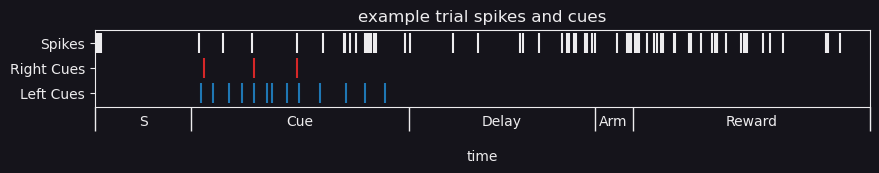

In [49]:
neuron = 10
trial_idx = np.nonzero(data["currMaze"] > 7)[0][18]
trial_start = data["trialStart"][trial_idx]
trial_end = data["trialEnd"][trial_idx]
trial_length = trial_end - trial_start
spikes = data["spikes"][neuron]
spikes = spikes[(spikes > trial_start) * (spikes < trial_end)]
keyframes = data["keyFrames"][trial_idx]
keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
lcue_times = data["cueOnset_L"][trial_idx]
rcue_times = data["cueOnset_R"][trial_idx]
fig, ax = plt.subplots(figsize=(10, 1))
ax.vlines(spikes - trial_start, 2.1, 2.9)
ax.vlines(lcue_times, 0.1, 0.9, colors="tab:blue")
ax.vlines(rcue_times, 1.1, 1.9, colors="tab:red")
ax.set_yticks(np.arange(0.5, 3, 1))
ax.set_yticklabels(["Left Cues", "Right Cues", "Spikes"])
trial_xticks(ax, xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
ax.set_xlim([0, trial_length])
ax.set_title("example trial spikes and cues")
ax.set_xlabel("time")
print(f"trial lengths = {trial_end - trial_start}")

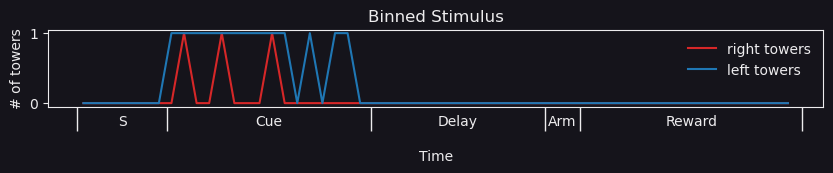

In [50]:
bins = np.arange(0, trial_length, 0.2)
bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")

fig, ax = plt.subplots(figsize=(10, 1))
binned_stimr, _ = np.histogram(rcue_times, bins)
plt.plot(bin_centers, binned_stimr, color=colors[0], label="right towers")
binned_stiml, _ = np.histogram(lcue_times, bins)
plt.plot(bin_centers, binned_stiml, color=colors[1], label="left towers")
trial_xticks(ax, xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
ax.set_ylabel("# of towers")
ax.set_title("Binned Stimulus")
ax.legend()

Text(0.5, 1.0, 'Binned Spikes')

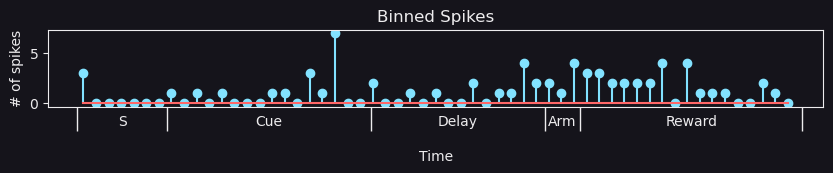

In [51]:
fig, ax = plt.subplots(figsize=(10, 1))
binned_spikes, _ = np.histogram(spikes - trial_start, bins)
plt.stem(bin_centers, binned_spikes, label="spikes")
trial_xticks(ax, xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
ax.set_ylabel("# of spikes")
ax.set_title("Binned Spikes")

(57, 10)

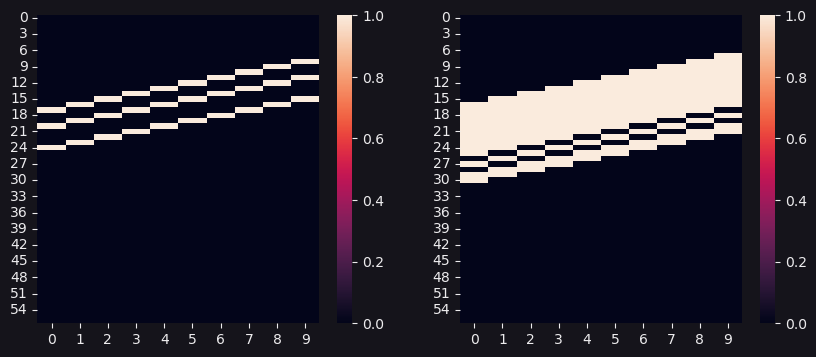

In [52]:
filt_len = 10
padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(X_sr, ax=axs[0])
sns.heatmap(X_sl, ax=axs[1])
X_sr.shape

(57, 10)

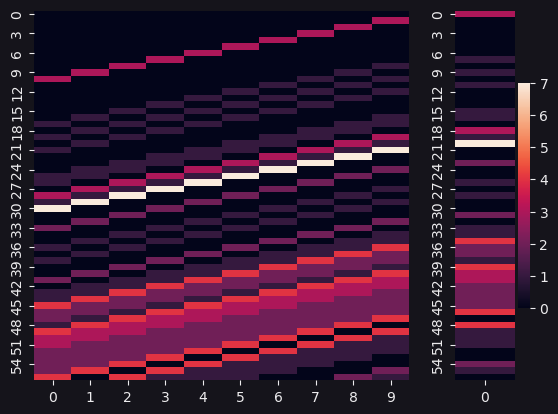

In [53]:
padded_spikes = np.pad(binned_spikes[:-1], (filt_len, 0), constant_values=(0, 0))
X_sp = hankel(padded_spikes[: -filt_len + 1], padded_spikes[-filt_len:])
fig, axs = plt.subplots(1, 2, gridspec_kw={"width_ratios": [5, 1]})
sns.heatmap(X_sp, ax=axs[0], cbar=False)
sns.heatmap(binned_spikes[:, np.newaxis], ax=axs[1])
X_sp.shape

In [249]:
neuron = 10
trial_indices = np.nonzero(data["currMaze"] > 7)[0]

X = []
y = []
filt_len = 25
bin_size = 0.3

for trial_idx in trial_indices:
    trial_start = data["trialStart"][trial_idx]
    trial_end = data["trialEnd"][trial_idx]
    trial_length = trial_end - trial_start
    spikes = data["spikes"][neuron]
    spikes = spikes[(spikes > trial_start) * (spikes < trial_end)]
    keyframes = data["keyFrames"][trial_idx]
    keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
    lcue_times = data["cueOnset_L"][trial_idx]
    rcue_times = data["cueOnset_R"][trial_idx]

    bins = np.arange(0, trial_length, bin_size)
    bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")

    binned_stimr, _ = np.histogram(rcue_times, bins)
    binned_stiml, _ = np.histogram(lcue_times, bins)
    binned_spikes, _ = np.histogram(spikes - trial_start, bins)

    padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
    X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
    padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
    X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])

    padded_spikes = np.pad(binned_spikes[:-1], (filt_len, 0), constant_values=(0, 0))
    X_sp = hankel(padded_spikes[: -filt_len + 1], padded_spikes[-filt_len:])

    X.append(np.hstack((X_sr, X_sl, X_sp, np.ones((X_sp.shape[0], 1)))))
    y.append(binned_spikes[:, np.newaxis])

X = np.vstack(X)
y = np.vstack(y)

In [250]:
t = time()
x0 = np.random.normal(0, 1, (X.shape[1], 1))
# bounds = tuple(zip(-1*np.ones(X.shape[1]), 1*np.ones(X.shape[1])))
res = minimize(nll, x0=x0, args=(X, y), options={"disp": False}, method="L-BFGS-B")
print((time() - t))

/tmp/ipykernel_108069/1010836979.py:4: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(nll, x0=x0, args=(X, y), options={"disp": False}, method="L-BFGS-B")


11.936964988708496


nLL: 7479.200577237984
-0.43615785160377657


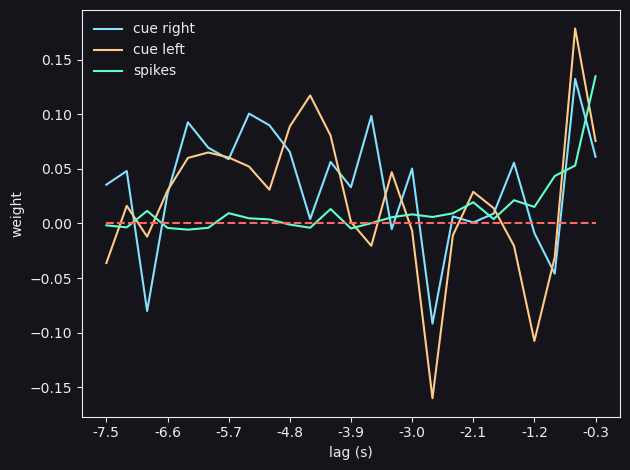

In [251]:
fig, ax = plt.subplots()
ax.plot(res.x[:-1].reshape(-1, filt_len).T, label=["cue right", "cue left", "spikes"])
ax.plot(np.arange(filt_len), np.zeros(filt_len), "--")
ax.legend()
xlabels = np.round(
    -1 * np.arange(bin_size, filt_len * bin_size + bin_size, bin_size)[::-3], 1
)
ax.set_xticks(np.arange(filt_len)[::3], xlabels)
ax.set_xlabel("lag (s)")
ax.set_ylabel("weight")
plt.tight_layout()
print(f"nLL: {res.fun}")
print(res.x[-1])

In [241]:
sta = (X.T @ y) / np.sum(y)  # compute STA for initialization

# -- Make loss functions and minimize -----
loss_func = lambda prs: np.array(
    neglogli_poissGLM(prs, X, y, bin_size, vals_to_return=0)
)
grad_func = lambda prs: np.array(
    neglogli_poissGLM(prs, X, y, bin_size, vals_to_return=1)
)
hess_func = lambda prs: np.array(
    neglogli_poissGLM(prs, X, y, bin_size, vals_to_return=2)
)
t = time()
res = minimize(
    fun=loss_func,
    x0=sta.squeeze(),
    method="trust-ncg",
    jac=grad_func,
    hess=hess_func,
    options={"disp": False, "gtol": 1e-6, "maxiter": 150},
)
print(time() - t)
filt_ML = res.x

11.374637603759766


nLL: 9942.971652926806
0.061475196585059885


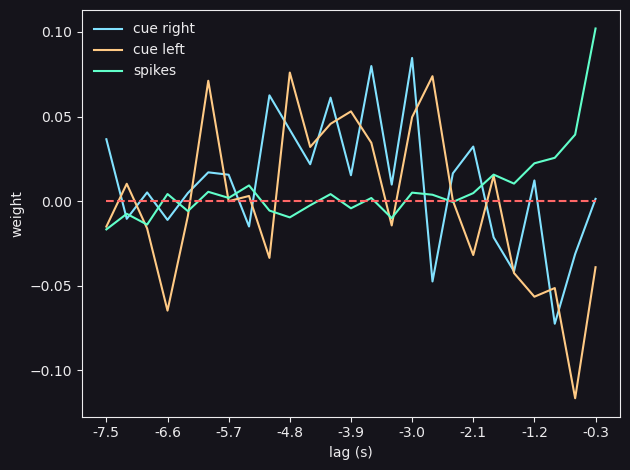

In [242]:
fig, ax = plt.subplots()
ax.plot(res.x[:-1].reshape(-1, filt_len).T, label=["cue right", "cue left", "spikes"])
ax.plot(np.arange(filt_len), np.zeros(filt_len), "--")
ax.legend()
xlabels = np.round(
    -1 * np.arange(bin_size, filt_len * bin_size + bin_size, bin_size)[::-3], 1
)
ax.set_xticks(np.arange(filt_len)[::3], xlabels)
ax.set_xlabel("lag (s)")
ax.set_ylabel("weight")
plt.tight_layout()
print(f"nLL: {res.fun}")
print(res.x[-1])

In [252]:
lam = 10000
Cinv = lam * np.identity(X.shape[1])  # set inverse prior covariance
Cinv[-1, -1] = 0
neglogli_func = lambda prs: neglogli_poissGLM(prs, X, y, bin_size)
loss_post_func = lambda prs: neglogposterior(prs, neglogli_func, Cinv, vals_to_return=0)
grad_post_func = lambda prs: neglogposterior(prs, neglogli_func, Cinv, vals_to_return=1)
hess_post_func = lambda prs: neglogposterior(prs, neglogli_func, Cinv, vals_to_return=2)
res = minimize(
    fun=loss_post_func,
    x0=sta.squeeze(),
    method="trust-ncg",
    jac=grad_post_func,
    hess=hess_post_func,
    tol=1e-6,
    options={"disp": False, "maxiter": 150},
)

KeyboardInterrupt: 

nLL: 10142.775793294531
0.06210110568764181


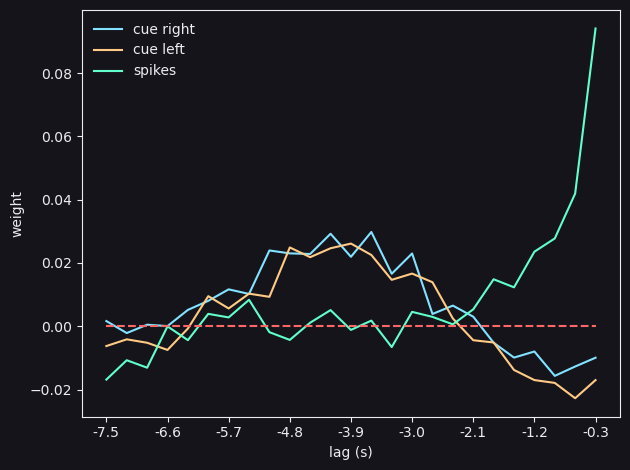

In [ ]:
fig, ax = plt.subplots()
ax.plot(res.x[:-1].reshape(-1, filt_len).T, label=["cue right", "cue left", "spikes"])
ax.plot(np.arange(filt_len), np.zeros(filt_len), "--")
ax.legend()
xlabels = np.round(
    -1 * np.arange(bin_size, filt_len * bin_size + bin_size, bin_size)[::-3], 1
)
ax.set_xticks(np.arange(filt_len)[::3], xlabels)
ax.set_xlabel("lag (s)")
ax.set_ylabel("weight")
plt.tight_layout()
print(f"nLL: {res.fun}")
print(res.x[-1])

233


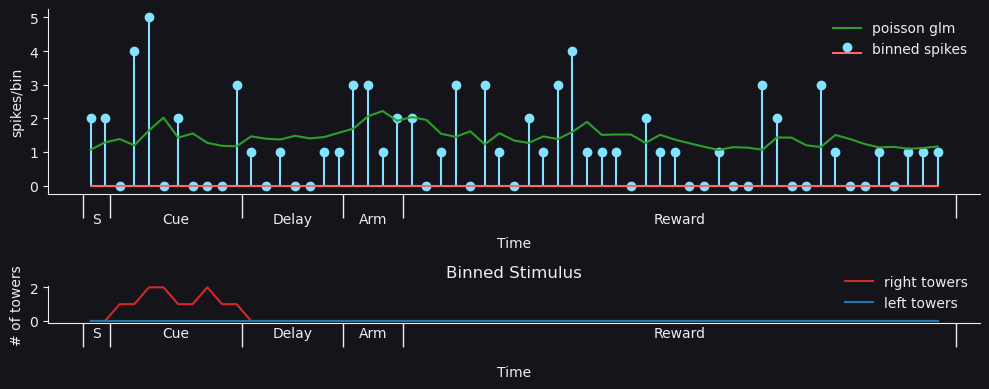

In [248]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={"height_ratios": [5, 1]})

w = res.x
sort_idx = np.argsort(data['nCues_RminusL'][data["currMaze"] > 7])  # ordered index of (lots of left cues) -> (lots of right cues)
plot_trial = sort_idx[-2]
print(sort_idx.size)

trial_idx = np.nonzero(data["currMaze"] > 7)[0][plot_trial]
trial_start = data["trialStart"][trial_idx]
trial_end = data["trialEnd"][trial_idx]
trial_length = trial_end - trial_start
spikes = data["spikes"][neuron]
spikes = spikes[(spikes > trial_start) * (spikes < trial_end)]
keyframes = data["keyFrames"][trial_idx]
keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
lcue_times = data["cueOnset_L"][trial_idx]
rcue_times = data["cueOnset_R"][trial_idx]
bins = np.arange(0, trial_length, bin_size)
bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")
binned_stimr, _ = np.histogram(rcue_times, bins)
binned_stiml, _ = np.histogram(lcue_times, bins)
binned_spikes, _ = np.histogram(spikes - trial_start, bins)

padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])

padded_spikes = np.pad(binned_spikes[:-1], (filt_len, 0), constant_values=(0, 0))
X_sp = hankel(padded_spikes[: -filt_len + 1], padded_spikes[-filt_len:])

X_plot = np.hstack((X_sr, X_sl, X_sp, np.ones((X_sp.shape[0], 1))))
y_plot = binned_spikes[:, np.newaxis]
# y_pred = np.exp(pGLM_const + X_plot[:, :-1] @ pGLM_filt)
y_pred = np.exp(X_plot @ w)

axs[0].stem(bin_centers, y_plot, label="binned spikes")
axs[0].plot(bin_centers, y_pred, color="tab:green", label="poisson glm")
trial_xticks(axs[0], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
axs[0].set_ylabel('spikes/bin')
axs[0].legend()


axs[1].plot(bin_centers, binned_stimr, color=colors[0], label="right towers")
axs[1].plot(bin_centers, binned_stiml, color=colors[1], label="left towers")
trial_xticks(axs[1], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
axs[1].set_ylabel("# of towers")
axs[1].set_title("Binned Stimulus")
axs[1].legend()
plt.tight_layout()
sns.despine()


<Axes: >

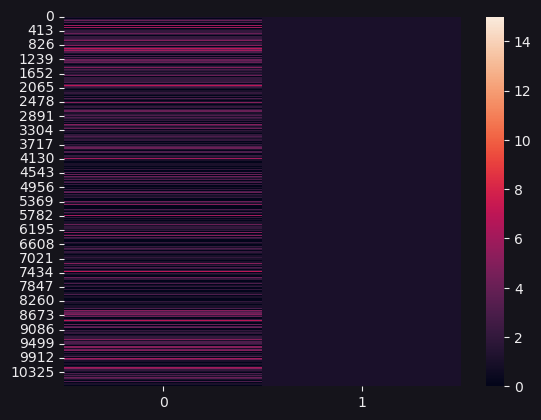

In [129]:
sns.heatmap(X[:, -2:])